# 作業目標:
## 利用手寫辨識資料說明MLP 中, 神經網路層的多寡跟預測結果的差異

# 作業重點:
## 請新增兩層MLP與三層MLP看看最後預測結果與一層的MLP是否有差異
## 請詳細說明修改的程式碼位置與你覺得為什麼會有差異?
## 請注意!!! 每一個block code都一定要在自己本機執行過後再上傳到雲端學院與github
## 請注意!!! ipynb檔名:Pytorch_Mnist_MLP_HW_學號.ipynb

參考程式: https://github.com/iam-mhaseeb/Multi-Layer-Perceptron-MNIST-with-PyTorch/blob/master/mnist_mlp_exercise.ipynb

In [1]:
# import libraries
import torch
import numpy as np

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

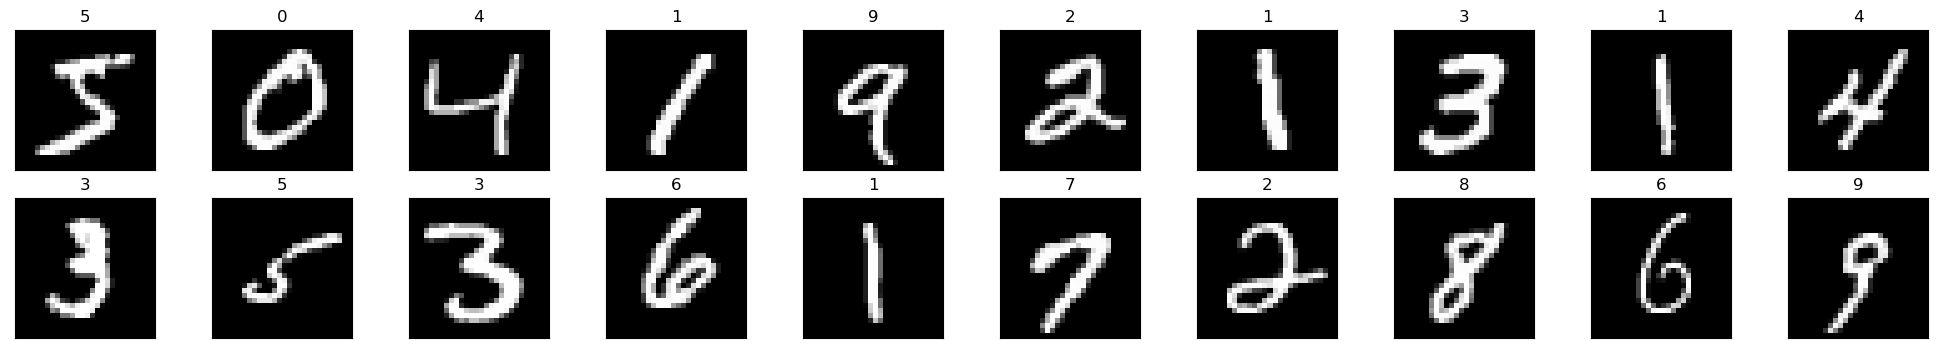

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Define the Network Architecture
    這個MLP架構將每個影像的784張量(pixel)視為輸入，並生成一個長度為10（class number）的張量。這個例子使用了兩個hidden layer和dropout 來避免overfitting

In [5]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## 定義loss function and optimizer (這裡選擇SGD)

In [6]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Training Model

In [7]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.826290
Epoch: 2 	Training Loss: 0.412346
Epoch: 3 	Training Loss: 0.370395
Epoch: 4 	Training Loss: 0.349184
Epoch: 5 	Training Loss: 0.335679
Epoch: 6 	Training Loss: 0.326068
Epoch: 7 	Training Loss: 0.318757
Epoch: 8 	Training Loss: 0.312944
Epoch: 9 	Training Loss: 0.308170
Epoch: 10 	Training Loss: 0.304154


## Testing Model

In [8]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.293053

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 97% (1104/1135)
Test Accuracy of     2: 87% (904/1032)
Test Accuracy of     3: 90% (912/1010)
Test Accuracy of     4: 92% (907/982)
Test Accuracy of     5: 87% (779/892)
Test Accuracy of     6: 94% (906/958)
Test Accuracy of     7: 91% (937/1028)
Test Accuracy of     8: 88% (858/974)
Test Accuracy of     9: 90% (911/1009)

Test Accuracy (Overall): 91% (9180/10000)


# 3 hidden layer

In [9]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 256)
        # linear layer (n_hidden_2 -> hidden_3)
        self.fc3 = nn.Linear(256, 128)
        # linear layer (n_hidden_3 -> 10)
        self.fc4 = nn.Linear(128, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [10]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.816220
Epoch: 2 	Training Loss: 0.412379
Epoch: 3 	Training Loss: 0.370541
Epoch: 4 	Training Loss: 0.349336
Epoch: 5 	Training Loss: 0.335815
Epoch: 6 	Training Loss: 0.326185
Epoch: 7 	Training Loss: 0.318857
Epoch: 8 	Training Loss: 0.313029
Epoch: 9 	Training Loss: 0.308243
Epoch: 10 	Training Loss: 0.304217


In [12]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.293280

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 97% (1106/1135)
Test Accuracy of     2: 87% (905/1032)
Test Accuracy of     3: 90% (913/1010)
Test Accuracy of     4: 92% (910/982)
Test Accuracy of     5: 87% (777/892)
Test Accuracy of     6: 94% (908/958)
Test Accuracy of     7: 91% (937/1028)
Test Accuracy of     8: 87% (857/974)
Test Accuracy of     9: 90% (911/1009)

Test Accuracy (Overall): 91% (9186/10000)


# 4 hidden layer

In [13]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 256)
        # linear layer (n_hidden_2 -> hidden_3)
        self.fc2 = nn.Linear(256, 128)
        # linear layer (n_hidden_3 -> hidden_4)
        self.fc2 = nn.Linear(128, 64)
        # linear layer (n_hidden_4 -> 10)
        self.fc3 = nn.Linear(64, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [14]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [15]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.804768
Epoch: 2 	Training Loss: 0.412563
Epoch: 3 	Training Loss: 0.370579
Epoch: 4 	Training Loss: 0.349320
Epoch: 5 	Training Loss: 0.335778
Epoch: 6 	Training Loss: 0.326141
Epoch: 7 	Training Loss: 0.318813
Epoch: 8 	Training Loss: 0.312986
Epoch: 9 	Training Loss: 0.308203
Epoch: 10 	Training Loss: 0.304180


In [16]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.293204

Test Accuracy of     0: 98% (963/980)
Test Accuracy of     1: 97% (1106/1135)
Test Accuracy of     2: 87% (907/1032)
Test Accuracy of     3: 90% (912/1010)
Test Accuracy of     4: 92% (909/982)
Test Accuracy of     5: 87% (777/892)
Test Accuracy of     6: 94% (905/958)
Test Accuracy of     7: 91% (937/1028)
Test Accuracy of     8: 87% (855/974)
Test Accuracy of     9: 90% (912/1009)

Test Accuracy (Overall): 91% (9183/10000)
